# Penalized Cox Models
Cox’s proportional hazard’s model is often an appealing model, because its coefficients can be interpreted in terms of hazard ratio, which often provides valuable insight. However, if we want to estimate the coefficients of many features, the standard Cox model falls apart, because internally it tries to invert a matrix that becomes non-singular due to correlations among features.



In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, glob, inspect, sys
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
from sklearn.exceptions import ConvergenceWarning

from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler


from sksurv.metrics import (concordance_index_censored,
                            concordance_index_ipcw,
                            cumulative_dynamic_auc)

In [28]:
df = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), '../Data/Merged_data/Survival_df.csv'),
                  index_col=0)
df

,Observed,F_Time,NDE_cycle,diff_two_peaks_ratio,amp_ratio,pos_ratio,energy_ratio,NLE_ratio_51_17,NLE_ratio_85_17,NLE_ratio_51_119,NLO_avg,Avg_RP,ACEE_30_Avg_58,ACEE_500_Avg_58,ACPD_Avg_58
ID,,,,,,,,,,,,,,,
41C,True,2154137.0,0,2.104871,1.185236,1.002988,1.559453,0.893268,1.107898,1.931463,5.576476,190.979294,-0.137640,-2.866030,4.804749
44C,True,1318034.0,0,2.280959,1.365329,0.998446,1.504218,0.888503,1.140535,1.862064,4.619563,187.204261,-0.596385,-2.788500,3.370729
45C,False,3245267.0,0,1.245687,0.809970,0.989351,1.282046,0.896534,1.137561,1.824140,3.458337,189.010633,-0.645710,-3.202220,4.186639
24C,False,1330000.0,300000,0.588694,1.061223,1.005517,1.030618,0.844482,1.030615,1.927292,5.064456,174.454983,-0.816755,-1.836935,4.259982
34C,False,700000.0,300000,0.589633,0.999639,1.002006,0.821495,0.780283,0.999564,1.719235,4.849455,170.036299,-1.014340,-1.521755,3.579960
19C,True,464392.0,450000,0.763296,1.128928,1.002407,1.126849,0.978877,1.235508,1.846582,3.798736,171.925123,-1.065155,-1.570740,3.226957
30C,True,1103303.0,450000,0.388101,1.069920,1.004996,0.932989,0.924855,1.195796,1.793760,3.513676,174.421961,-0.968130,-1.248220,3.305279
32C,True,306142.0,450000,0.610771,1.137713,0.994283,0.844962,0.844824,1.091099,1.839907,4.296261,169.717689,-0.617190,-1.312415,2.907922
46C,True,447380.0,450000,0.742724,0.917101,0.977985,0.946441,0.892038,1.188698,1.748973,6.444959,172.526654,-1.064230,-1.176100,3.526969


In [48]:
df_x.dtypes

NDE_cycle                 int64
diff_two_peaks_ratio    float64
amp_ratio               float64
pos_ratio               float64
energy_ratio            float64
NLE_ratio_51_17         float64
NLE_ratio_85_17         float64
NLE_ratio_51_119        float64
NLO_avg                 float64
Avg_RP                  float64
ACEE_30_Avg_58          float64
ACEE_500_Avg_58         float64
ACPD_Avg_58             float64
dtype: object

In [58]:
df_x['NDE_cycle']=df_x['NDE_cycle'].astype('category')

In [59]:
df_x.dtypes

NDE_cycle               category
diff_two_peaks_ratio     float64
amp_ratio                float64
pos_ratio                float64
energy_ratio             float64
NLE_ratio_51_17          float64
NLE_ratio_85_17          float64
NLE_ratio_51_119         float64
NLO_avg                  float64
Avg_RP                   float64
ACEE_30_Avg_58           float64
ACEE_500_Avg_58          float64
ACPD_Avg_58              float64
dtype: object

In [60]:
df_y=df.iloc[:, :2]
df_x=df.iloc[:, 2:]

In [61]:
df_y=df_y.to_records(index=False)

In [62]:
df_x_scale=df_x.copy()

In [63]:

df_x_scale[[ 'diff_two_peaks_ratio',
       'amp_ratio', 'pos_ratio', 'energy_ratio', 'NLE_ratio_51_17',
       'NLE_ratio_85_17', 'NLE_ratio_51_119', 'NLO_avg', 'Avg_RP',
       'ACEE_30_Avg_58', 'ACEE_500_Avg_58', 'ACPD_Avg_58']] = MinMaxScaler().fit_transform(df_x_scale[[ 'diff_two_peaks_ratio',
       'amp_ratio', 'pos_ratio', 'energy_ratio', 'NLE_ratio_51_17',
       'NLE_ratio_85_17', 'NLE_ratio_51_119', 'NLO_avg', 'Avg_RP',
       'ACEE_30_Avg_58', 'ACEE_500_Avg_58', 'ACPD_Avg_58']])

In [33]:
df_x_scale

,NDE_cycle,diff_two_peaks_ratio,amp_ratio,pos_ratio,energy_ratio,NLE_ratio_51_17,NLE_ratio_85_17,NLE_ratio_51_119,NLO_avg,Avg_RP,ACEE_30_Avg_58,ACEE_500_Avg_58,ACPD_Avg_58
ID,,,,,,,,,,,,,
41C,0,0.917593,0.746081,0.668912,1.000000,0.568927,0.459151,0.647705,0.523859,1.000000,1.000000,0.147772,1.000000
44C,0,1.000000,1.000000,0.547397,0.952577,0.544931,0.597476,0.435903,0.324522,0.822448,0.597138,0.181850,0.409761
45C,0,0.515506,0.216983,0.304071,0.761826,0.585372,0.584872,0.320162,0.082626,0.907408,0.553822,0.000000,0.745587
24C,300000,0.208042,0.571232,0.736591,0.545956,0.323266,0.131602,0.634975,0.417199,0.222810,0.403613,0.600108,0.775775
34C,300000,0.208481,0.484403,0.642647,0.366409,0.000000,0.000000,0.000000,0.372412,0.014985,0.230097,0.738645,0.495879
19C,450000,0.289753,0.666691,0.653390,0.628578,1.000000,1.000000,0.388655,0.153535,0.103823,0.185472,0.717114,0.350584
30C,450000,0.114167,0.583494,0.722656,0.462135,0.727981,0.831687,0.227444,0.094153,0.221257,0.270678,0.858877,0.382822
32C,450000,0.218374,0.679078,0.436020,0.386556,0.324990,0.387950,0.368283,0.257175,0.000000,0.578867,0.830660,0.219270
46C,450000,0.280126,0.368030,0.000000,0.473684,0.562729,0.801606,0.090757,0.704774,0.132114,0.186285,0.890577,0.474069


CoxPHSurvivalAnalysis and CoxnetSurvivalAnalysis are related but do not implement the same model. As you summarized, the difference is in penalty terms. Thus, the coefficients found by CoxPHSurvivalAnalysis and CoxnetSurvivalAnalysis will differ. In addition, CoxnetSurvivalAnalysis supports fitting a path of coefficients for varying penalization strength alpha without much computational overhead. CoxPHSurvivalAnalysis will return the result for a single a penalization strength alpha only. This is the main reason why constructors differ.

# Ridge 

This mathematical problem can be avoided by adding a ℓ2 penalty term on the coefficients that shrinks the coefficients to zero. The modified objective has the form

                argmaxβlogPL(β)−α2∑j=1pβ2j,

where PL(β) is the partial likelihood function of the Cox model, β1,…,βp are the coefficients for p features, and α≥0 is a hyper-parameter that controls the amount of shrinkage. The resulting objective is often referred to as ridge regression. If λ is set to zero, we obtain the standard, unpenalized Cox model.

Let us begin by fitting a penalized Cox model to various values of α using sksurv.linear_model.CoxPHSurvivalAnalysis and recording the coefficients we obtained for each α.

In [9]:
alphas = 10. ** np.linspace(-4, 4, 50)
coefficients = {}

cph = CoxPHSurvivalAnalysis()
for alpha in alphas:
    cph.set_params(alpha=alpha)
    cph.fit(df_x_scale, df_y)
    key = round(alpha, 7)
    coefficients[key] = cph.coef_

coefficients = (pd.DataFrame
    .from_dict(coefficients)
    .rename_axis(index="feature", columns="alpha")
    .set_index(df_x_scale.columns))

Now, we can inspect how the coefficients change for varying α.

In [244]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(12, 8))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + "  ",
            horizontalalignment="right",
            verticalalignment="center"
        )

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

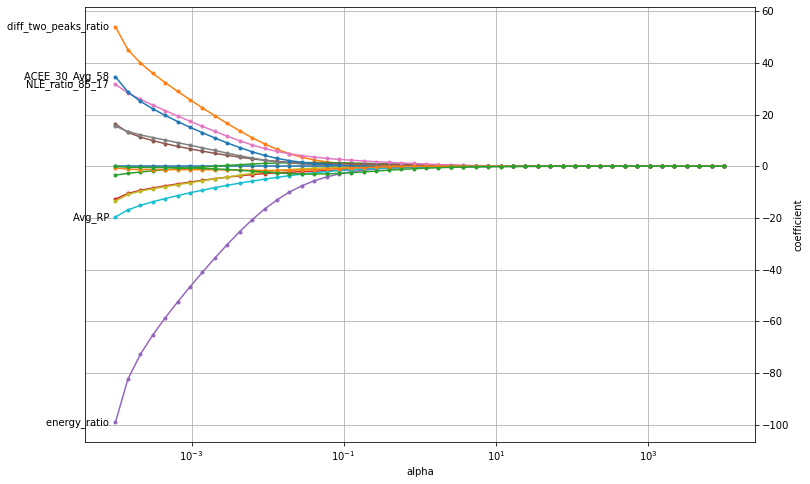

In [245]:
plot_coefficients(coefficients, n_highlight=5)

We can see that if the penalty has a large weight (to the right), all coefficients are shrunk almost to zero. As the penalty’s weight is decreased, the coefficients’ value increases.


# Lasso 

While the ℓ2 (ridge) penalty does solve the mathematical problem of fitting a Cox model, we would still need to measure the expression levels of all 76 genes to make predictions. Ideally, we would like to select a small subset of features that are most predictive and ignore the remaining gene expression levels. This is precisely what the LASSO (Least Absolute Shrinkage and Selection Operator) penalty does. Instead of shrinking coefficients to zero it does a type of continuous subset selection, where a subset of coefficients are set to zero and are effectively excluded. This reduces the number of features that we would need to record for prediction. In mathematical terms, the ℓ2 penalty is replaced by a ℓ1 penalty, which leads to the optimization problem

                argmaxβlogPL(β)−α∑j=1p|βj|.

The main challenge is that we cannot directly control the number of features that get selected, but the value of α implicitly determines the number of features. Thus, we need a data-driven way to select a suitable α and obtain a parsimonious model. We can do this by first computing the α that would ignore all features (coefficients are all zero) and then incrementally decrease its value, let’s say until we reach 1% of the original value. This has been implemented in sksurv.linear_model.CoxnetSurvivalAnalysis by specifying l1_ratio=1.0 to use the LASSO penalty and alpha_min_ratio=0.01 to search for 100 α values up to 1% of the estimated maximum

In [246]:
cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01) # decrease alpha since all coeff are zerp expect NDE_cyle
cox_lasso.fit(df_x_scale, df_y)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9)

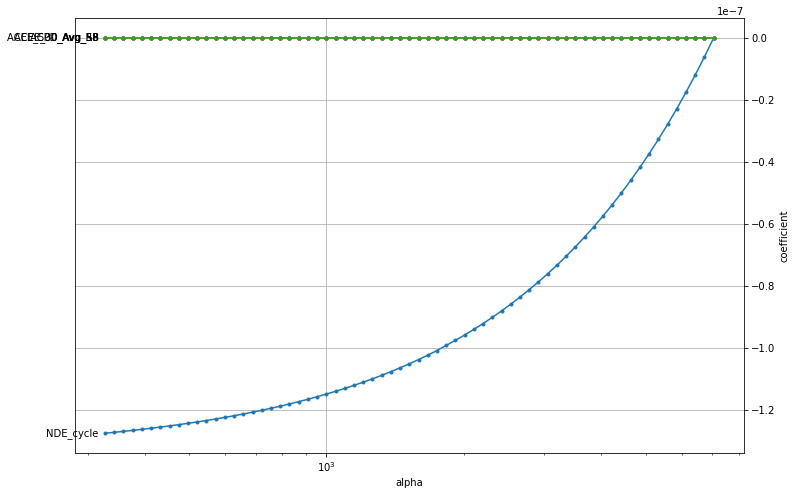

In [247]:
coefficients_lasso = pd.DataFrame(
    cox_lasso.coef_,
    index=df_x_scale.columns,
    columns=np.round(cox_lasso.alphas_, 5)
)

plot_coefficients(coefficients_lasso, n_highlight=5)

In [248]:
# Lasso excludes all features except NDE_cycle, drop NDE_cycle for this model since it has small significance on predictor
df_x_scale.drop(['NDE_cycle'],axis=1, inplace=True)

In [249]:
cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01) 
cox_lasso.fit(df_x_scale, df_y)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=1.0)

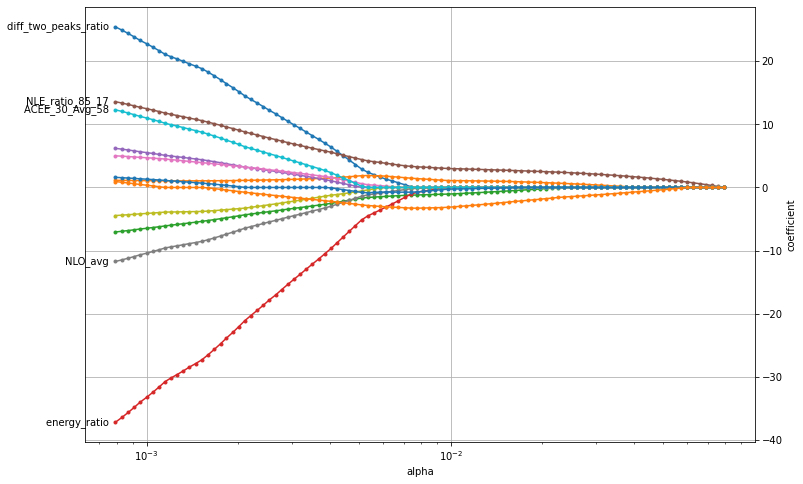

In [250]:
coefficients_lasso = pd.DataFrame(
    cox_lasso.coef_,
    index=df_x_scale.columns,
    columns=np.round(cox_lasso.alphas_, 5)
)

plot_coefficients(coefficients_lasso, n_highlight=5)

# Elastic Net
The LASSO is a great tool to select a subset of discriminative features, but it has two main drawbacks. First, it cannot select more features than number of samples in the training data, which is problematic when dealing with very high-dimensional data. Second, if data contains a group of features that are highly correlated, the LASSO penalty is going to randomly choose one feature from this group. The Elastic Net penalty overcomes these problems by using a weighted combination of the ℓ1 and ℓ2 penalty by solving:

                argmaxβlogPL(β)−α(r∑j=1p|βj|+1−r2∑j=1pβ2j),
        
where r∈[0;1[ is the relative weight of the ℓ1 and ℓ2 penalty. The Elastic Net penalty combines the subset selection property of the LASSO with the regularization strength of the Ridge penalty. This leads to better stability compared to the LASSO penalized model. For a group of highly correlated features, the latter would choose one feature randomly, whereas the Elastic Net penalized model would tend to select all. Usually, it is sufficient to give the ℓ2 penalty only a small weight to improve stability of the LASSO, e.g. by setting r=0.9.

As for the LASSO, the weight α implicitly determines the size of the selected subset, and usually has to be estimated in a data-driven manner

In [251]:
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
cox_elastic_net.fit(df_x_scale, df_y)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9)

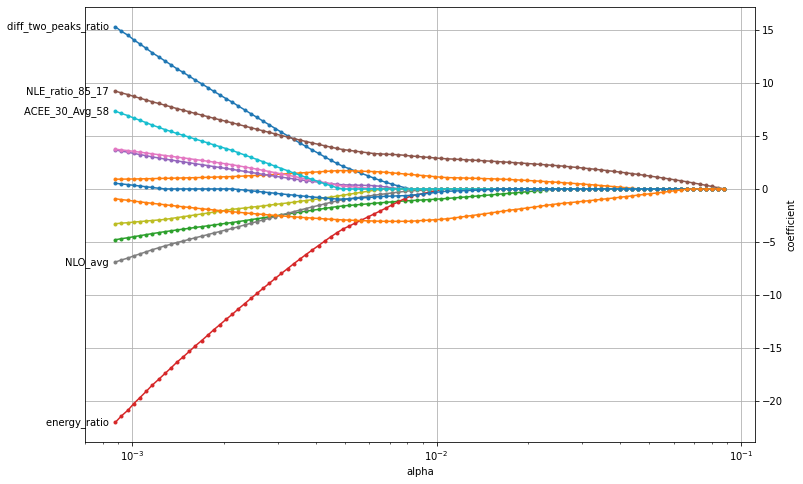

In [252]:
coefficients_elastic_net = pd.DataFrame(
    cox_elastic_net.coef_,
    index=df_x_scale.columns,
    columns=np.round(cox_elastic_net.alphas_, 5)
)
plot_coefficients(coefficients_elastic_net, n_highlight=5)

# Choosing penalty strength α 

Previously, we focused on the estimated coefficients to get some insight into which features are important for estimating time to failure. However, for prediction, we need to pick one particular α, and the subset of features it implies. Here, we are going to use cross-validation to determine which subset and α generalizes best.

Before we can use GridSearchCV, we need to determine the set of α which we want to evaluate. To do this, we fit a penalized Cox model to the whole data and retrieve the estimated set of alphas. Since, we are only interested in alphas and not the coefficients, we can use only a few iterations for improved speed. Note that we are using MinMaxScaler() to account for scale differences among features and allow direct comparison of coefficients.

In [37]:
coxnet_pipe = make_pipeline(
    MinMaxScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01, max_iter=100)
)

warnings.simplefilter("ignore", ConvergenceWarning)
coxnet_pipe.fit(df_x, df_y)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9,
                                        max_iter=100))])

Using the estimated set of alphas, we perform 4 fold cross-validation to estimate the performance – in terms of concordance index – for each α.

In [38]:
# Reducing th ratio below 0.9 brings the threshold to the left of the elastic net graph hence will display more non-zero coefficients

cv = KFold(n_splits=4, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(MinMaxScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=4).fit(df_x, df_y)

cv_results = pd.DataFrame(gcv.cv_results_)


In [34]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_coxnetsurvivalanalysis__alphas,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.023998,4.182399e-03,0.007002,5.431853e-03,[0.0001],{'coxnetsurvivalanalysis__alphas': [0.0001]},0.428571,0.500000,0.428571,0.75,0.526786,0.132131,6
1,0.031749,1.420148e-02,0.005994,6.042226e-03,[0.00014563484775012445],{'coxnetsurvivalanalysis__alphas': [0.00014563...,0.428571,0.500000,0.428571,0.75,0.526786,0.132131,6
2,0.024509,6.541045e-03,0.003249,4.332271e-04,[0.00021209508879201905],{'coxnetsurvivalanalysis__alphas': [0.00021209...,0.428571,0.500000,0.428571,0.75,0.526786,0.132131,6
3,0.017493,3.561011e-03,0.003507,4.938495e-04,[0.00030888435964774815],{'coxnetsurvivalanalysis__alphas': [0.00030888...,0.428571,0.500000,0.428571,0.75,0.526786,0.132131,6
4,0.014247,3.491908e-03,0.004744,1.290674e-03,[0.0004498432668969444],{'coxnetsurvivalanalysis__alphas': [0.00044984...,0.428571,0.500000,0.428571,0.75,0.526786,0.132131,6
5,0.021508,4.018499e-03,0.009007,6.055362e-03,[0.0006551285568595509],{'coxnetsurvivalanalysis__alphas': [0.00065512...,0.428571,0.500000,0.428571,0.75,0.526786,0.132131,6
6,0.012243,4.375338e-03,0.002750,4.348391e-04,[0.0009540954763499944],{'coxnetsurvivalanalysis__alphas': [0.00095409...,0.428571,0.500000,0.428571,0.75,0.526786,0.132131,6
7,0.014250,7.222691e-03,0.003000,7.087430e-04,[0.0013894954943731374],{'coxnetsurvivalanalysis__alphas': [0.00138949...,0.428571,0.500000,0.428571,0.75,0.526786,0.132131,6
8,0.008491,3.285045e-03,0.004008,1.727800e-03,[0.0020235896477251557],{'coxnetsurvivalanalysis__alphas': [0.00202358...,0.428571,0.500000,0.428571,0.75,0.526786,0.132131,6
9,0.008993,5.250346e-03,0.006009,1.425768e-03,[0.0029470517025518097],{'coxnetsurvivalanalysis__alphas': [0.00294705...,0.428571,0.500000,0.428571,0.75,0.526786,0.132131,6


We can visualize the results by plotting the mean concordance index and its standard deviation across all folds for each α.

0.6309523809523809


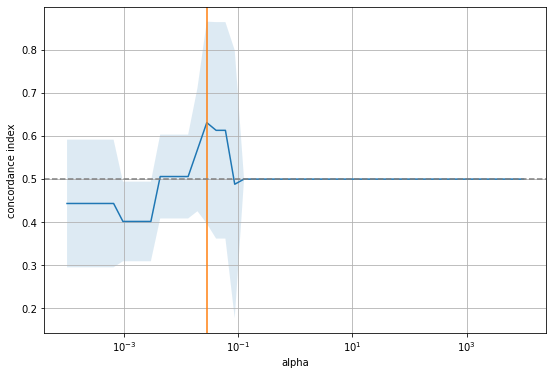

In [39]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

print(cv_results.mean_test_score.max())

The figure shows that there is a range for α to the right where it is too large and sets all coefficients to zero, as indicated by the 0.5 concordance index of a purely random model. On the other extreme, if α becomes too small, too many features enter the model and the performance approaches that of a random model again. The sweet spot (orange line) is somewhere in the middle. Let’s inspect that model.

Number of non-zero coefficients: 3


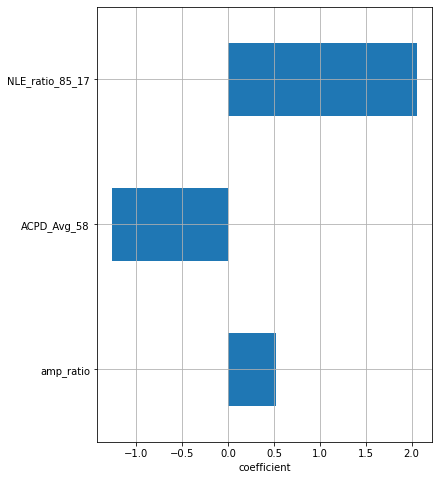

In [40]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=df_x.columns,
    columns=["coefficient"]
)

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print("Number of non-zero coefficients: {}".format(non_zero))

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

# Survival and Cumulative Hazard Function
Having selected a particular α, we can perform prediction, either in terms of risk score using the predict function or in terms of survival or cumulative hazard function. For the latter two, we first need to re-fit the model with fit_baseline_model enabled.

In [64]:
coxnet_pred = make_pipeline(
    MinMaxScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.9, fit_baseline_model=True)
)
coxnet_pred.set_params(**gcv.best_params_)
coxnet_pred.fit(df_x, df_y)



Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alphas=[0.02811768697974228],
                                        fit_baseline_model=True,
                                        l1_ratio=0.9))])

In [42]:
coxnet_pred.score(df_x, df_y)

0.7986111111111112

In [17]:
coxnet_pred.predict_survival_function(df_x)

array([StepFunction(x=array([ 200007.,  297627.,  306142.,  447380.,  464392.,  514878.,
        603724.,  700000., 1103303., 1266052., 1318034., 1330000.,
       1444844., 1537912., 2101992., 2103203., 2143805., 2154137.,
       2255225., 2829121., 3245267.]), y=array([0.97927569, 0.95758022, 0.93525154, 0.91224563, 0.88787393,
       0.85906968, 0.8274193 , 0.8274193 , 0.79305002, 0.79305002,
       0.75103106, 0.75103106, 0.75103106, 0.75103106, 0.75103106,
       0.75103106, 0.75103106, 0.63248273, 0.63248273, 0.63248273,
       0.63248273]), a=1.0, b=0.0),
       StepFunction(x=array([ 200007.,  297627.,  306142.,  447380.,  464392.,  514878.,
        603724.,  700000., 1103303., 1266052., 1318034., 1330000.,
       1444844., 1537912., 2101992., 2103203., 2143805., 2154137.,
       2255225., 2829121., 3245267.]), y=array([0.93538456, 0.87087473, 0.80774144, 0.74605571, 0.68432061,
       0.61599159, 0.54648093, 0.54648093, 0.47731581, 0.47731581,
       0.40123086, 0.40123086, 0.4

For instance, we can now select a specimen and determine how a specific feature would affect the survival function.

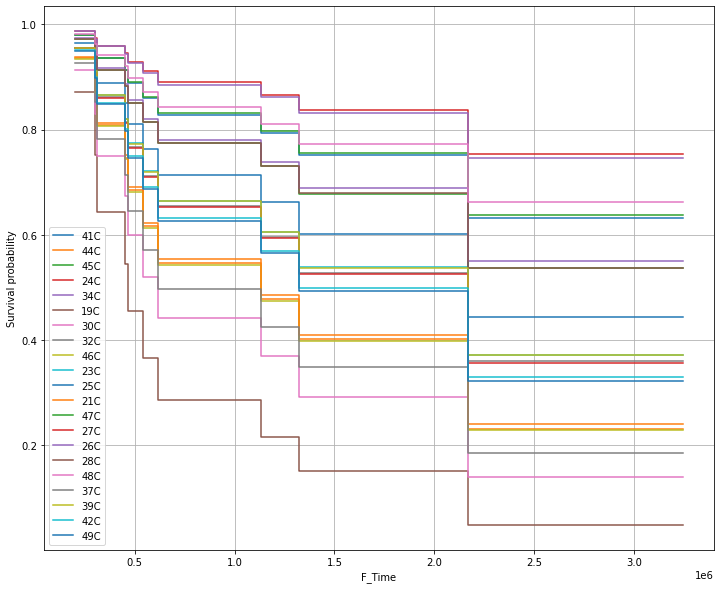

In [93]:
surv_fns = coxnet_pred.predict_survival_function(df_x)


time_points =df_y["F_Time"]
time_points =np.percentile(df_y["F_Time"], np.linspace(0, 100))

_, ax = plt.subplots(figsize=(12, 10))
for fn, label in zip(surv_fns, df_x.loc[:, "NDE_cycle"].astype(int)):
    line, = ax.step(time_points, fn(time_points), where="post",
                    alpha=1)
 

ax.legend(df_x.index) 
ax.set_xlabel("F_Time")
ax.set_ylabel("Survival probability")
ax.grid(True)

## For specific specimens and how a feature affects the survival 

In [22]:
df_3_7=df_x.iloc[3:7, :]
df_7_10=df_x.iloc[7:10, :]

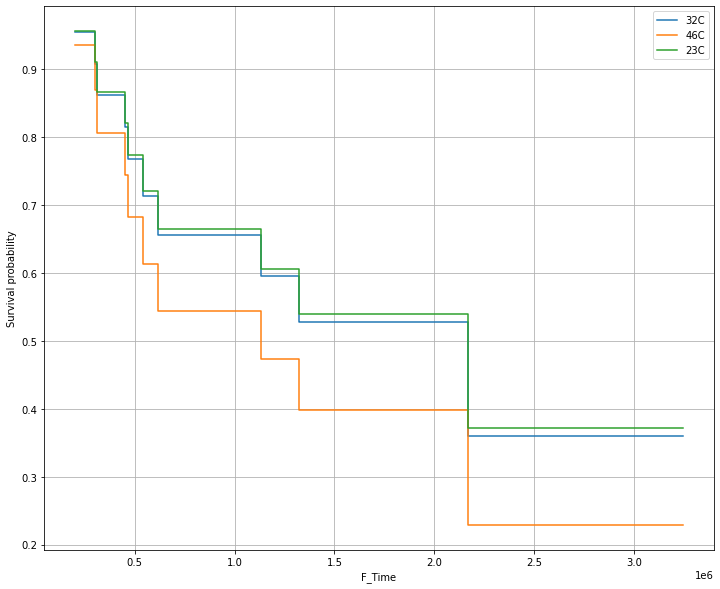

In [80]:
surv_fns = coxnet_pred.predict_survival_function(df_7_10)


time_points =df_y["F_Time"]
time_points =np.percentile(df_y["F_Time"], np.linspace(0, 100))

_, ax = plt.subplots(figsize=(12, 10))
for fn, label in zip(surv_fns, df.loc[:, "NLE_ratio_85_17"].astype(int)):
    line, = ax.step(time_points, fn(time_points), where="post",
                    alpha=1)
 

ax.legend(df_7_10.index) 
ax.set_xlabel("F_Time")
ax.set_ylabel("Survival probability")
ax.grid(True)

NDE with lower NLE_ratio_85_17 is observed to have a longer F_Time but in dataframe 46C has longer F_Time than 32C ????

# End

In [82]:
def calc_median_survival(survival_func):
    '''
    Calculate the median survival as the time when survival probability falls below 0.5
    If it doesn't fall below 0.5 then it will be set as the last time point observed
    Args:
    - survival_func: array of survival functions returned by predict_survival_function()
    returns: 
    - median_survival_list: list of median survival times
    '''
    median_survival_list = []
    for fn in survival_func:
        found_list = np.where(fn(fn.x) <= 0.5)[0]
        if len(found_list) != 0:
            found_index = np.min(found_list)
            median_survival_list.append(fn.x[found_index])
        else:
            median_survival_list.append(fn.x[len(fn.x)-1])
    return median_survival_list

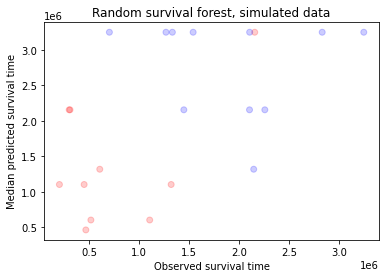

In [86]:
median_survival_list = calc_median_survival(surv_fns)
colordict = {False:'blue', True:'red'}
plt.scatter(x=df_y.F_Time,y=median_survival_list,c=[colordict[c] for c in df_y.Observed],alpha=0.2)
plt.ylabel("Median predicted survival time")
plt.xlabel("Observed survival time")
plt.title("Random survival forest, simulated data")
plt.show()

In [87]:
median_survival_list

[3245267.0,
 1103303.0,
 3245267.0,
 3245267.0,
 3245267.0,
 464392.0,
 603724.0,
 2154137.0,
 1103303.0,
 2154137.0,
 2154137.0,
 1103303.0,
 3245267.0,
 2154137.0,
 3245267.0,
 3245267.0,
 3245267.0,
 603724.0,
 2154137.0,
 1318034.0,
 1318034.0]